In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import sklearn
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

# Any results you write to the current directory are saved as output.

[Logistic Regression Baseline](#logisticRegressionBaseline)

[Random Forest Baseline](#randomForestBaseline)

In [2]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')

In [3]:
test.shape

(48744, 121)

In [4]:
def missing_values_table(df):
    total_missing = df.isnull().sum()
    perc_missing = df.isnull().sum() * 100/ len(df)
    missing_total_perc = pd.concat([total_missing, perc_missing], axis=1)
    missing_total_perc.columns = ['total', 'percentage']
    missing_total_perc = missing_total_perc.sort_values('percentage', ascending=False).round(1)
    return missing_total_perc

In [5]:
#no of unique values in object columns
train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [6]:
le = LabelEncoder()

le_count = 0

for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) < 3:
            le.fit(train[col])
            print(col)
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY


In [7]:
train_dummied = pd.get_dummies(train)
test_dummied = pd.get_dummies(test)

In [8]:
train_labels = train.TARGET

In [9]:
app_train, app_test = train_dummied.align(test_dummied, join='inner', axis=1)

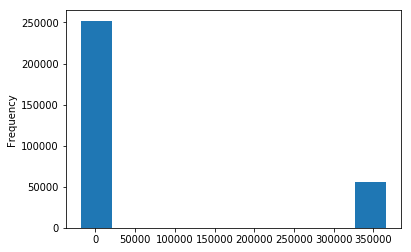

In [10]:
app_train.DAYS_EMPLOYED.plot.hist()

In [11]:
app_train['DAYS_EMPLOYED_ANOMALOUS'] = app_train['DAYS_EMPLOYED'] >= 300000
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_test['DAYS_EMPLOYED_ANOMALOUS'] = app_test['DAYS_EMPLOYED'] >= 300000
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

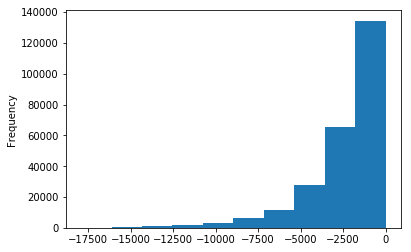

In [12]:
app_train.DAYS_EMPLOYED.plot.hist()

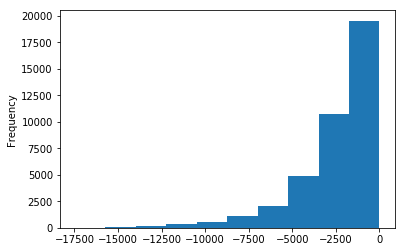

In [13]:
app_test.DAYS_EMPLOYED.plot.hist()

Text(0,0.5,'Count')

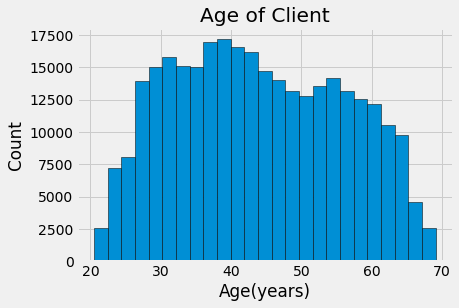

In [14]:
plt.style.use('fivethirtyeight')

plt.hist(app_train.DAYS_BIRTH /-365, edgecolor = 'k', bins=25)
plt.title('Age of Client'); plt.xlabel('Age(years)'); plt.ylabel('Count')

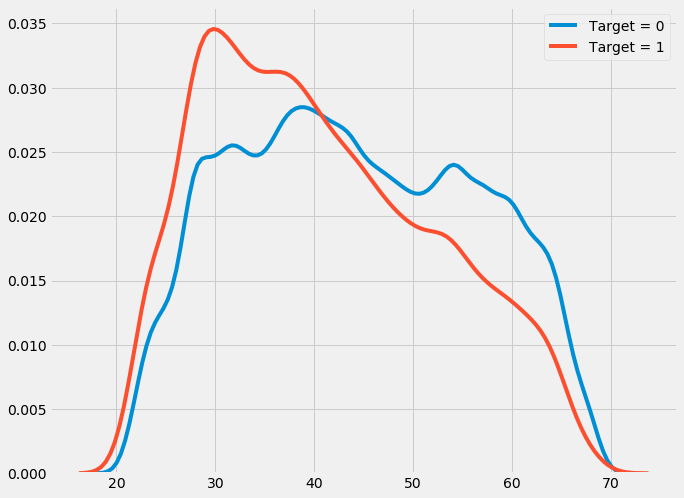

In [15]:
app_train['TARGET'] = train.TARGET
plt.figure(figsize=(10, 8))

sns.kdeplot(app_train.loc[app_train.TARGET == 0, 'DAYS_BIRTH']/-365, label='Target = 0')
sns.kdeplot(app_train.loc[app_train.TARGET == 1, 'DAYS_BIRTH']/-365, label='Target = 1')

In [16]:

pd.options.mode.chained_assignment = None  # default='warn'
age_data = train[['TARGET', 'DAYS_BIRTH']]
#age_data['YEARS_BIRTH'] = 0
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / -365

In [17]:
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins=np.linspace(20, 70, num=11))

In [18]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,-8532.795625,23.377522
"(25.0, 30.0]",0.111436,-10155.219250,27.822518
"(30.0, 35.0]",0.102814,-11854.848377,32.479037
"(35.0, 40.0]",0.089414,-13707.908253,37.555913
"(40.0, 45.0]",0.078491,-15497.661233,42.459346
"(45.0, 50.0]",0.074171,-17323.900441,47.462741
"(50.0, 55.0]",0.066968,-19196.494791,52.593136
"(55.0, 60.0]",0.055314,-20984.262742,57.491131
"(60.0, 65.0]",0.052737,-22780.547460,62.412459


<BarContainer object of 10 artists>

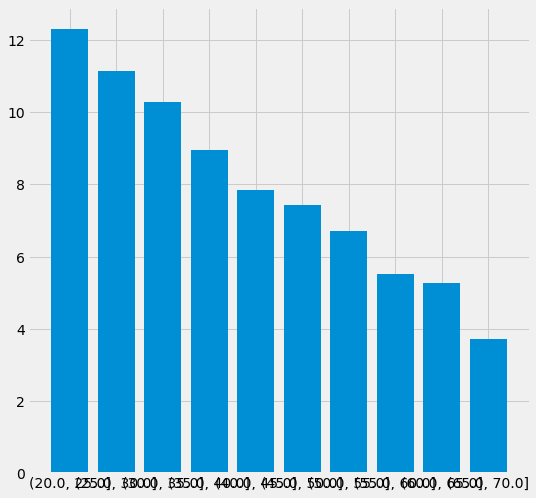

In [19]:
plt.figure(figsize=(8, 8))

plt.bar(age_groups.index.astype(str), 100 *age_groups.TARGET)

In [20]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [21]:
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


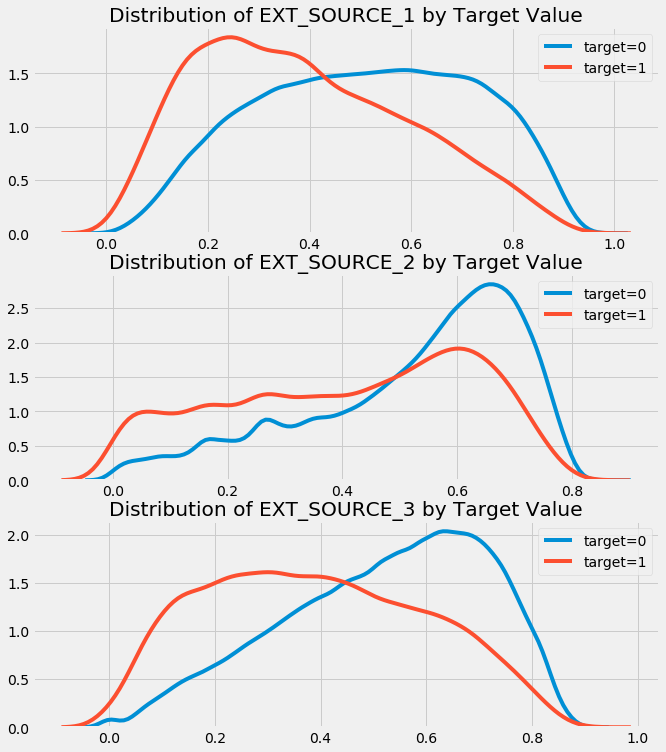

In [22]:
plt.figure(figsize=(10,12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] ==0, source], label="target=0")
    sns.kdeplot(app_train.loc[app_train['TARGET'] ==1, source], label="target=1")
    
    plt.title('Distribution of %s by Target Value'%(source))

In [23]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET', 'DAYS_BIRTH']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

from sklearn.preprocessing import Imputer

simple_imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns='TARGET')

poly_features = simple_imputer.fit_transform(poly_features)
poly_features_test = simple_imputer.fit_transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)

In [24]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print ('Polynomial features shape %s'%(str(poly_features.shape)))

Polynomial features shape (307511, 35)


In [25]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [26]:
poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print("tail")
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
tail
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


In [27]:
poly_features_test = pd.DataFrame(poly_features_test, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

print('Training data with polynomials %s and testing shape with polynomials is %s'%(str(app_train_poly.shape), str(app_test_poly.shape)))

Training data with polynomials (307511, 275) and testing shape with polynomials is (48744, 275)


In [28]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain.AMT_INCOME_TOTAL
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain.AMT_ANNUITY / app_train_domain.AMT_INCOME_TOTAL
app_train_domain['CREDIT_TERM'] = app_train_domain.AMT_ANNUITY / app_train_domain.AMT_CREDIT
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain.DAYS_EMPLOYED / app_train_domain.DAYS_BIRTH

In [29]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain.AMT_INCOME_TOTAL
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain.AMT_ANNUITY / app_test_domain.AMT_INCOME_TOTAL
app_test_domain['CREDIT_TERM'] = app_test_domain.AMT_ANNUITY / app_test_domain.AMT_CREDIT
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain.DAYS_EMPLOYED / app_test_domain.DAYS_BIRTH

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


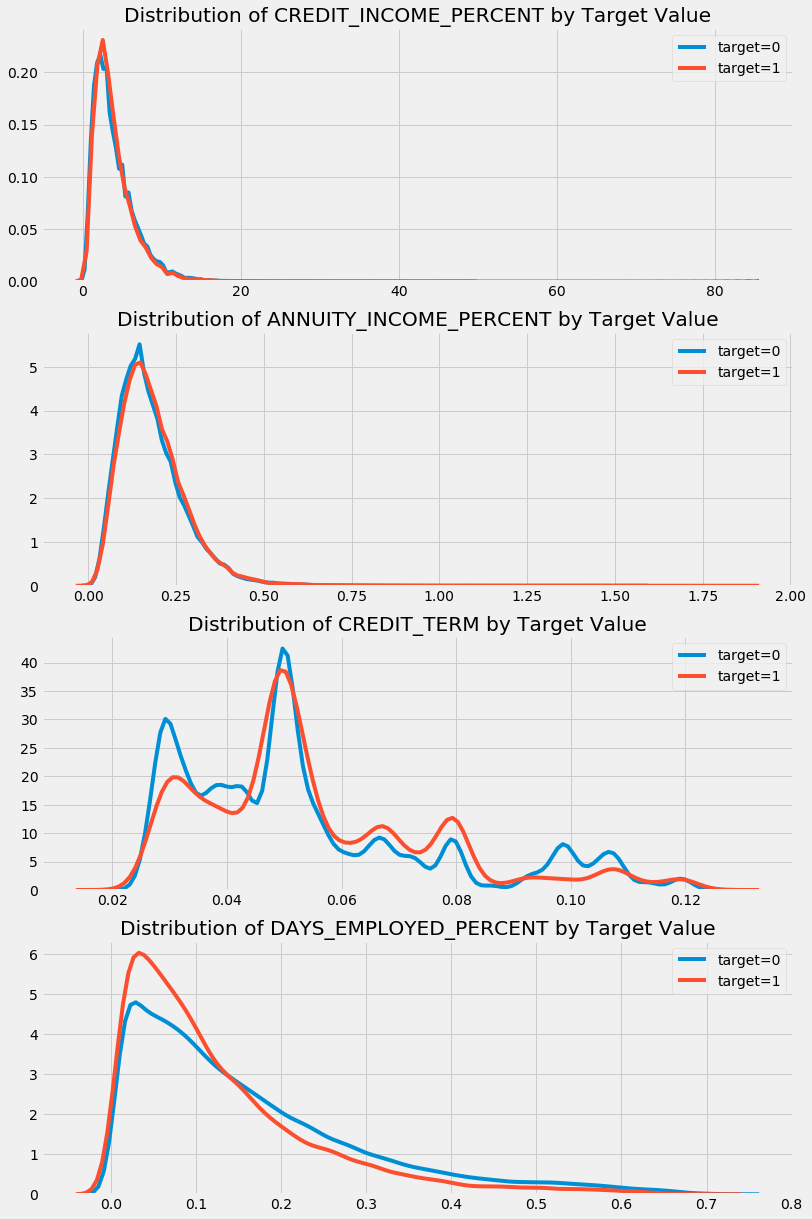

In [30]:
plt.figure(figsize=(12,20))

for i, source in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'  ]):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] ==0, source], label="target=0")
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] ==1, source], label="target=1")
    
    plt.title('Distribution of %s by Target Value'%(source))

<a id="logisticRegressionBaseline">Starting Logistic Regression</a>

In [32]:

from sklearn.preprocessing import MinMaxScaler

imputer = Imputer(strategy='median')
scaler = MinMaxScaler()

if 'TARGET' in app_train:
    train = app_train.drop(columns='TARGET')
else:
    train = app_train.copy()

features = list(train.columns)

test = app_test.copy()

imputer.fit(train)

train = imputer.transform(train)
test =  imputer.transform(test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print ('shape of training is %s and shape of testing is %s'%(str(train.shape), str(test.shape)))

shape of training is (307511, 240) and shape of testing is (48744, 240)


In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train, train_labels)

In [ ]:
log_reg_pred = log_reg.predict_proba(test)[:,1]

In [ ]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.to_csv('log_reg_baseline.csv', index=False)

<a id="randomForestBaseline">Random Forest Baseline</a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

random_forest.fit(train, train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

predictions = random_forest.predict_proba(test)[:,1]

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline.csv', index=False)

In [ ]:

poly_features_names = list(app_train_poly.columns)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

print('Starting imputer fit...')
poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

In [ ]:
random_forest_poly = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=50, verbose=1)

print('Fitting random forest model ...')
random_forest_poly.fit(poly_features, train_labels)

print('Predicting ..')
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
poly_features_names

In [ ]:
submit = app_test[['SK_ID_CURR']]

submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index=False)

In [ ]:
assert poly_features.shape[1] == len(poly_feature_names)

In [ ]:
poly_features_test.shape

In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')
from sklearn.ensemble import RandomForestClassifier
domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')
print('fit and transform train')
domain_features = imputer.fit_transform(app_train_domain)
print('transform test')
domain_features_test = imputer.transform(app_test_domain)

In [ ]:
# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

print('fit transform scaler')
domain_features = scaler.fit_transform(domain_features)
print('transform scaler test')
domain_features_test = scaler.transform(domain_features_test)

In [ ]:
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

print('fit random forest')
# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

In [ ]:
# Make predictions on the test data
print('predict random forest')
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions
submit.to_csv('random_forest_baseline_domain.csv', index=False)

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

In [73]:
def plot_feature_importances(df): 
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

def model(train, test, n_folds=5):
   
    
    train_ids = train['SK_ID_CURR']
    test_ids = test['SK_ID_CURR']
    
    labels = train['TARGET']
    
    train = train.drop(columns=['TARGET', 'SK_ID_CURR'])
    test = test.drop(columns=['SK_ID_CURR'])
    
    train_colnames = list(train.columns)
    
    train = np.array(train)
    test = np.array(test)
    
    print('Training shape is %s and testing shape is %s'%(str(train.shape), str(test.shape)))
    
    k_fold = KFold(n_splits=5, random_state=50, shuffle=True)
    
    feature_importance_values = np.zeros(len(train_colnames))
    test_predictions = np.zeros(test.shape[0])
    out_of_fold = np.zeros(train.shape[0])
    
    valid_scores = []
    train_scores = []
    
    for train_indices, val_indices in k_fold.split(train):
        
        train_features, train_labels = train[train_indices], labels[train_indices]
        valid_features, valid_labels = train[val_indices], labels[val_indices]
        
        model = lgb.LGBMClassifier(class_weight='balanced', 
                                   n_estimators=10000, 
                                   objective='binary', learning_rate=0.5, reg_alpha=0.1, reg_lambda=0.1,
                                   random_state=50, subsample=0.8, n_jobs=-1)
        model.fit(train_features, train_labels, eval_metric='auc', 
                  eval_names=['valid', 'train'], categorical_feature='auto', early_stopping_rounds=100,
                 eval_set = [(valid_features, valid_labels), (train_features, train_labels)], verbose=True)
        
        best_iteration = model.best_iteration_
        feature_importance_values += model.feature_importances_/k_fold.n_splits
        test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:,1] /k_fold.n_splits
        
        out_of_fold[val_indices] = model.predict_proba(valid_features, num_iteration=best_iteration)[:,1]
        
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    feature_importances = pd.DataFrame({'feature': train_colnames, 'importance': feature_importance_values})
    valid_auc = roc_auc_score(labels, out_of_fold)
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
    
    return submission, feature_importances, metrics
        

In [68]:
app_train['TARGET'] = train.TARGET
submission, feat_imp, metrics = model(app_train, app_test)

Training shape is (307511, 239) and testing shape is (48744, 239)
[1]	valid's auc: 0.712763	train's auc: 0.722152
Training until validation scores don't improve for 100 rounds.
[2]	valid's auc: 0.722835	train's auc: 0.733988
[3]	valid's auc: 0.729257	train's auc: 0.742818
[4]	valid's auc: 0.733842	train's auc: 0.749264
[5]	valid's auc: 0.737896	train's auc: 0.755034
[6]	valid's auc: 0.740194	train's auc: 0.759665
[7]	valid's auc: 0.742515	train's auc: 0.762818
[8]	valid's auc: 0.743213	train's auc: 0.765566
[9]	valid's auc: 0.744302	train's auc: 0.768268
[10]	valid's auc: 0.744352	train's auc: 0.77049
[11]	valid's auc: 0.746099	train's auc: 0.773019
[12]	valid's auc: 0.74673	train's auc: 0.775017
[13]	valid's auc: 0.746694	train's auc: 0.776769
[14]	valid's auc: 0.746951	train's auc: 0.778854
[15]	valid's auc: 0.746442	train's auc: 0.780846
[16]	valid's auc: 0.746375	train's auc: 0.782333
[17]	valid's auc: 0.746268	train's auc: 0.783809
[18]	valid's auc: 0.746512	train's auc: 0.785558


[50]	valid's auc: 0.743411	train's auc: 0.824351
[51]	valid's auc: 0.74314	train's auc: 0.825655
[52]	valid's auc: 0.743275	train's auc: 0.826807
[53]	valid's auc: 0.743625	train's auc: 0.827894
[54]	valid's auc: 0.743292	train's auc: 0.829077
[55]	valid's auc: 0.743165	train's auc: 0.830108
[56]	valid's auc: 0.742784	train's auc: 0.831194
[57]	valid's auc: 0.74264	train's auc: 0.831977
[58]	valid's auc: 0.742627	train's auc: 0.832729
[59]	valid's auc: 0.741922	train's auc: 0.833754
[60]	valid's auc: 0.741752	train's auc: 0.834648
[61]	valid's auc: 0.741497	train's auc: 0.835943
[62]	valid's auc: 0.741608	train's auc: 0.836966
[63]	valid's auc: 0.741578	train's auc: 0.838009
[64]	valid's auc: 0.740982	train's auc: 0.839058
[65]	valid's auc: 0.740876	train's auc: 0.839847
[66]	valid's auc: 0.7407	train's auc: 0.840525
[67]	valid's auc: 0.740454	train's auc: 0.841096
[68]	valid's auc: 0.740452	train's auc: 0.842058
[69]	valid's auc: 0.740123	train's auc: 0.843049
[70]	valid's auc: 0.7397

[95]	valid's auc: 0.738268	train's auc: 0.865722
[96]	valid's auc: 0.738297	train's auc: 0.866546
[97]	valid's auc: 0.737959	train's auc: 0.867279
[98]	valid's auc: 0.737535	train's auc: 0.86819
[99]	valid's auc: 0.737283	train's auc: 0.869114
[100]	valid's auc: 0.736626	train's auc: 0.869805
[101]	valid's auc: 0.736436	train's auc: 0.870441
[102]	valid's auc: 0.736226	train's auc: 0.871202
[103]	valid's auc: 0.735896	train's auc: 0.871978
[104]	valid's auc: 0.735512	train's auc: 0.872721
[105]	valid's auc: 0.735468	train's auc: 0.873554
[106]	valid's auc: 0.735617	train's auc: 0.874399
[107]	valid's auc: 0.735581	train's auc: 0.875163
[108]	valid's auc: 0.73519	train's auc: 0.875974
[109]	valid's auc: 0.735369	train's auc: 0.876591
[110]	valid's auc: 0.735352	train's auc: 0.877027
[111]	valid's auc: 0.735187	train's auc: 0.877842
[112]	valid's auc: 0.735289	train's auc: 0.878325
[113]	valid's auc: 0.735388	train's auc: 0.879073
[114]	valid's auc: 0.735206	train's auc: 0.879822
[115]	v

[26]	valid's auc: 0.748387	train's auc: 0.796751
[27]	valid's auc: 0.748113	train's auc: 0.797841
[28]	valid's auc: 0.747838	train's auc: 0.798842
[29]	valid's auc: 0.747802	train's auc: 0.800093
[30]	valid's auc: 0.747559	train's auc: 0.801044
[31]	valid's auc: 0.74739	train's auc: 0.802055
[32]	valid's auc: 0.74661	train's auc: 0.803318
[33]	valid's auc: 0.746173	train's auc: 0.804495
[34]	valid's auc: 0.746248	train's auc: 0.80588
[35]	valid's auc: 0.746436	train's auc: 0.807435
[36]	valid's auc: 0.745855	train's auc: 0.808681
[37]	valid's auc: 0.745365	train's auc: 0.810031
[38]	valid's auc: 0.744904	train's auc: 0.811463
[39]	valid's auc: 0.745004	train's auc: 0.812467
[40]	valid's auc: 0.745035	train's auc: 0.813344
[41]	valid's auc: 0.744876	train's auc: 0.814392
[42]	valid's auc: 0.744513	train's auc: 0.815482
[43]	valid's auc: 0.744353	train's auc: 0.816812
[44]	valid's auc: 0.74402	train's auc: 0.818068
[45]	valid's auc: 0.743946	train's auc: 0.819197
[46]	valid's auc: 0.7435

In [69]:
print(metrics)

      fold     train     valid
0        0  0.778854  0.746951
1        1  0.788125  0.749837
2        2  0.779350  0.754184
3        3  0.782579  0.748397
4        4  0.783439  0.750475
5  overall  0.782470  0.749945


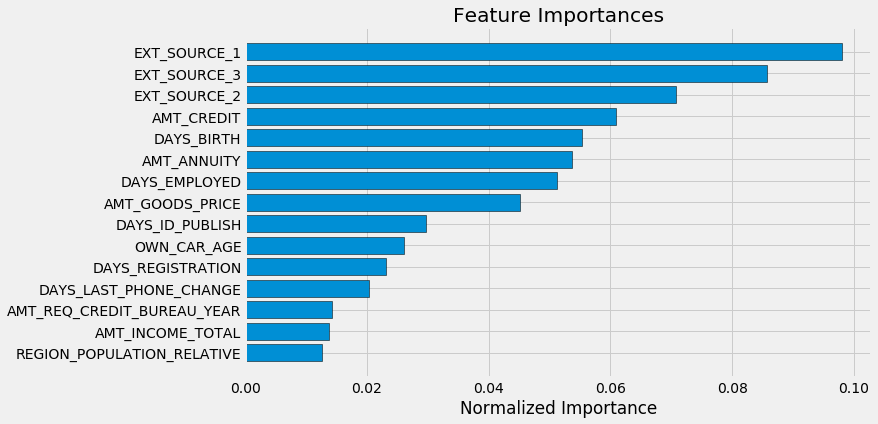

In [75]:
fi_sorted = plot_feature_importances(feat_imp)

In [76]:
submission.to_csv('baseline_lgb_domain_features.csv', index=False)